## Causal Inference for Wine Quality Enhancement

**Dataset**: observational data, Wine Quality dataset
- 1599 instances w/ 11 chemical properties (e.g., acidity, alcohol content) features from (UCI ML repository) https://archive.ics.uci.edu/dataset/186/wine+quality
- This data contains quality ratings from 0-10.
Note: we will only use red wine subset of data.

**Causal inference**: estimating the effect of a treatment (cause) on an outcome while controlling for confounders

**Causal questions to explore:**

Q. Does higher alcohol content in wine causally increase wine quality?(i.e., Does higher alcohol content lead to a significant improvement or decline in wine quality?)
- Why this matters? Alcohol content is highly correlated with wine quality, but is it truly causal, or are other factors driving this relationship?
- Binary treatment (low vs high)
- Technique: PSM (Propensity Score Matching) with ATE
    
    - Treatment (T): alcohol
    - Outcome (Y): wine_quality
    - Confounders (C): All other features; acidity, sugar, sulfur dioxide levels, density, etc.

Since Randomized Controlled Tests (RCTs) are not feasible now and we are using observational data, we will use Quasi-experimental methods.

### 1. Preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [49]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/winequality-red.csv"
url = '/Users/lisafukutoku/UCI_Local/STATS240P_S23_Local/winequality-red.csv'
df = pd.read_csv(url, delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [50]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [51]:
# basic stats
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [9]:
# Check for missing values
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### 2. EDA

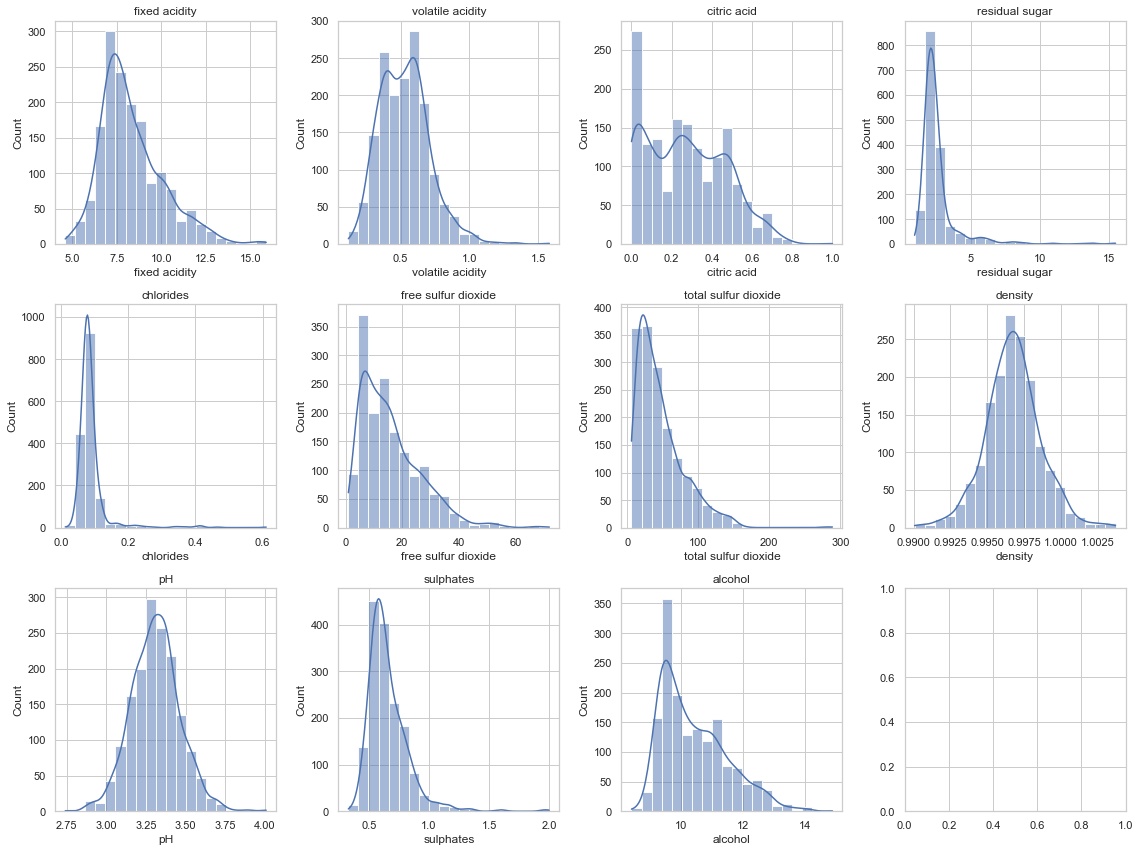

In [10]:
# Visualize the distribution of each feature (boxplots, histograms)
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Plot histograms for each feature
for i, column in enumerate(df.columns[:-1]):  # Exclude 'quality' for now
    ax = axes[i // 4, i % 4]
    sns.histplot(df[column], ax=ax, kde=True, bins=20)
    ax.set_title(column)

plt.tight_layout()
plt.show()

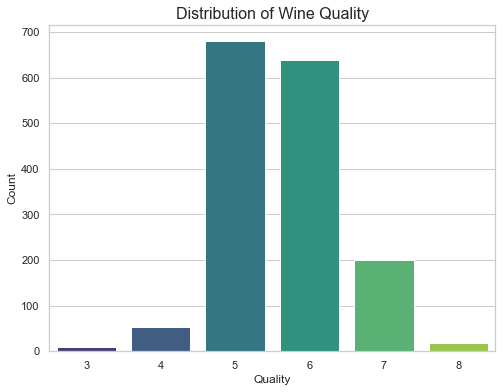

In [11]:
# Visualize the distribution of wine quality
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=df, palette='viridis')

# Add labels and title
plt.title('Distribution of Wine Quality', fontsize=16)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()

In [20]:
df_scaled = df.copy()

# Define the continuous features to be standardized (all except 'quality')
continuous_features = df_scaled.drop(columns=['quality'])

# Standardize the features
scaler = StandardScaler()
df_scaled[continuous_features.columns] = scaler.fit_transform(continuous_features)
df_scaled.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,5
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,5
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,6
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,5


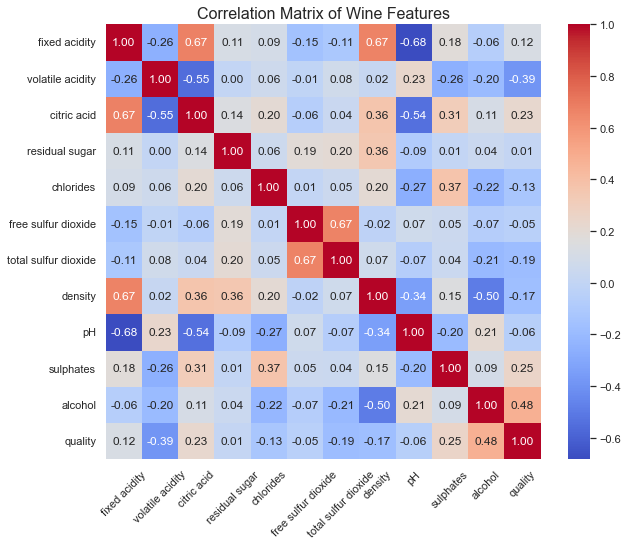

In [22]:
# Compute the correlation matrix
corr_matrix = df_scaled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix of Wine Features', fontsize=16)
plt.xticks(rotation=45)
plt.show()

### 3. Causal Inference Analysis

#### 3-1. Does higher alcohol content in wine causally increase wine quality?  
  -- i.e., Does higher alcohol content lead to a significant improvement or decline in wine quality?
    
**Propensity Score Matching (PSM)**  
PSM will help match wines with similar characteristics (e.g., acidity, residual sugar) but different alcohol contents, to estimate the average treatment effect of alcohol content on wine quality.

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors


# Define treatment variable (Alcohol content: above or below median)
df['high_alcohol'] = (df['alcohol'] > df['alcohol'].median()).astype(int)  # Treatment: Above median alcohol content

# Outcome variable: Wine quality
outcome = "quality"

# Select confounders (other factors that affect wine quality)
confounders = ['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
               'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates']

# Standardize confounders for better propensity score estimation
scaler = StandardScaler()
df[confounders] = scaler.fit_transform(df[confounders])

#### Estimate Propensity Scores using Logistic Regression
(in the causal inference world, the simpler, the better)

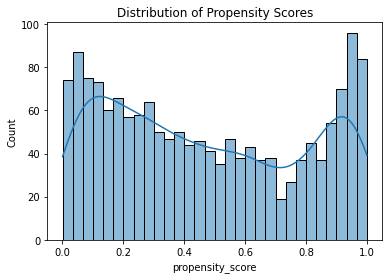

In [43]:
# Logistic regression to estimate propensity scores
X = df[confounders]  # Covariates
y = df['high_alcohol']  # Treatment variable

propensity_model = LogisticRegression(max_iter=1000)
propensity_model.fit(X, y)
df['propensity_score'] = propensity_model.predict_proba(X)[:, 1]

# Visualize the distribution of propensity scores
sns.histplot(df['propensity_score'], bins=30, kde=True)
plt.title("Distribution of Propensity Scores")
plt.show()

In [44]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,high_alcohol,propensity_score
0,7.4,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,9.4,5,0,0.099110
1,7.8,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,9.8,5,0,0.085979
2,7.8,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,9.8,5,0,0.091783
3,11.2,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,9.8,6,0,0.266960
4,7.4,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,9.4,5,0,0.099110


#### Perform Matching using NN
To find suitable matches, we can use unsupervised learning. We'll use the classic nearest neighbors (NN) algorithm matching based on propensity scores.

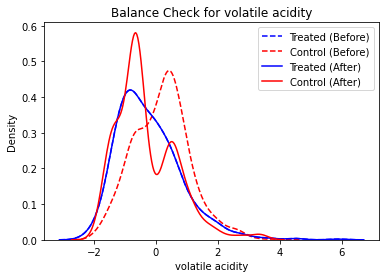

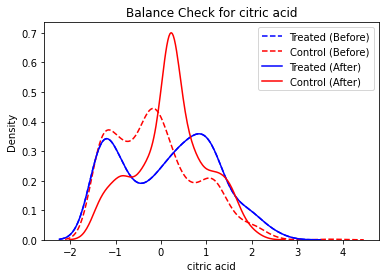

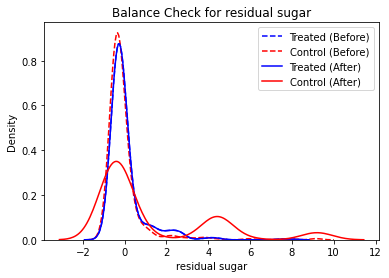

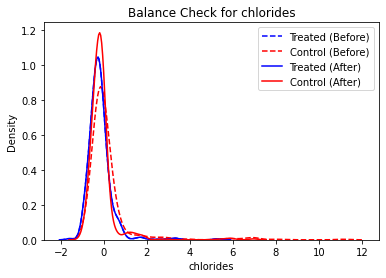

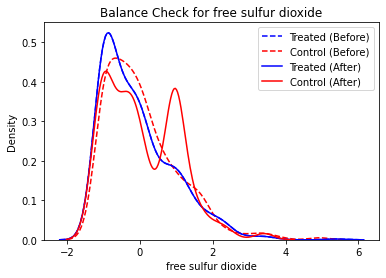

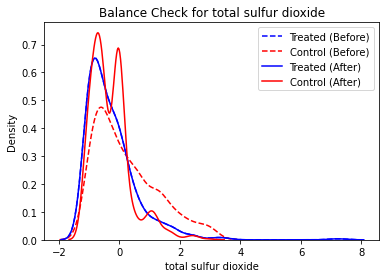

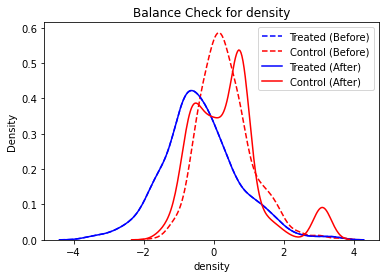

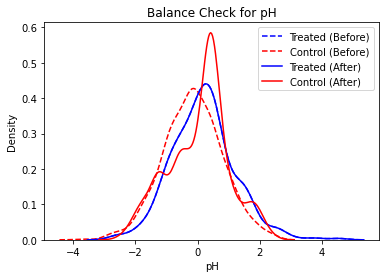

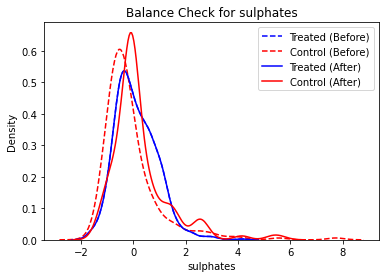

Average Treatment Effect (ATE): 0.346


In [47]:
## Using 1 nearest neighbors for matching
## Use n_neighbors=1 to find the closest match in the control group for each treated unit
## (as we seek the most precise match for each unit in the treatment group)

# Separate treated and control groups
treated = df[df['high_alcohol'] == 1]
control = df[df['high_alcohol'] == 0]

# Use Nearest Neighbors for matching
# by applying the NN model to the control group
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find nearest neighbors (match treated samples to control samples based on propensity score)
# by applying the kNeighbors method to the treatment group
# distances: measures similarity between treatment and control units
# indices: provides indices of the closest matches in the control group
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control samples
# This constructs a new control group containing only the closest matches for each treated unit
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)

# Combine matched treated and control samples (the original treatment group with the newly matched control group)
matched_df = pd.concat([matched_treated, matched_control], axis=0)
matched_df = matched_df.reset_index(drop=True)

# Balance check of confounders after matching
# This verifies that the matching process improved balance in confounder distributions
for conf in confounders:
    plt.figure(figsize=(6,4))
    
    # Before matching
    sns.kdeplot(df[df['high_alcohol'] == 1][conf], label="Treated (Before)", color='blue', linestyle="dashed")
    sns.kdeplot(df[df['high_alcohol'] == 0][conf], label="Control (Before)", color='red', linestyle="dashed")

    # After matching
    sns.kdeplot(matched_df[matched_df['high_alcohol'] == 1][conf], label="Treated (After)", color='blue')
    sns.kdeplot(matched_df[matched_df['high_alcohol'] == 0][conf], label="Control (After)", color='red')

    plt.title(f"Balance Check for {conf}")
    plt.legend()
    plt.show()

# Compute Average Treatment Effect (ATE)
# By comparing the mean outcome in matched treatment and control groups
treated_quality = matched_df[matched_df['high_alcohol'] == 1][outcome].mean()
control_quality = matched_df[matched_df['high_alcohol'] == 0][outcome].mean()

ATE = treated_quality - control_quality
print(f"Average Treatment Effect (ATE): {ATE:.3f}")

---

**Conclusion to the causal question**

Q. Does higher alcohol content in wine causally increase wine quality?

A. The Average Treatment Effect (ATE) of 0.346 indicates that, on average, an increase in alcohol content is associated with a 34.6% improvement in wine quality (on a scale from 0 to 10). This result suggests a positive causal relationship between alcohol content and wine quality, where higher alcohol content leads to higher wine quality.

---

**Limitation**  
SM has several limitations, mainly related to the reliance on data quality and the assumption that all relevant confounders are accounted for. The following points highlight some of these challenges:
- Dependence on Available Data: PSM relies on the assumption that all relevant confounders are included in the analysis. If an important confounder is missing, the estimated treatment effect may be biased.
- Unmeasured Confounders: If there are confounders that affect both the treatment (alcohol content) and the outcome (wine quality) but aren't measured or included, the results may be inaccurate.
- Data Quality: The effectiveness of PSM depends on the quality and completeness of the data. Missing or inaccurate data on key covariates could lead to biased estimates.
- No Test for Unobserved Confounders: There's no way to directly test for unmeasured confounders, so caution and domain expertise are required to ensure all relevant variables are included.
- Method Sensitivity: PSM works best when the treatment assignment is well explained by the included covariates. If the treatment effect is complex or influenced by unaccounted factors, PSM may not provide a reliable estimate.

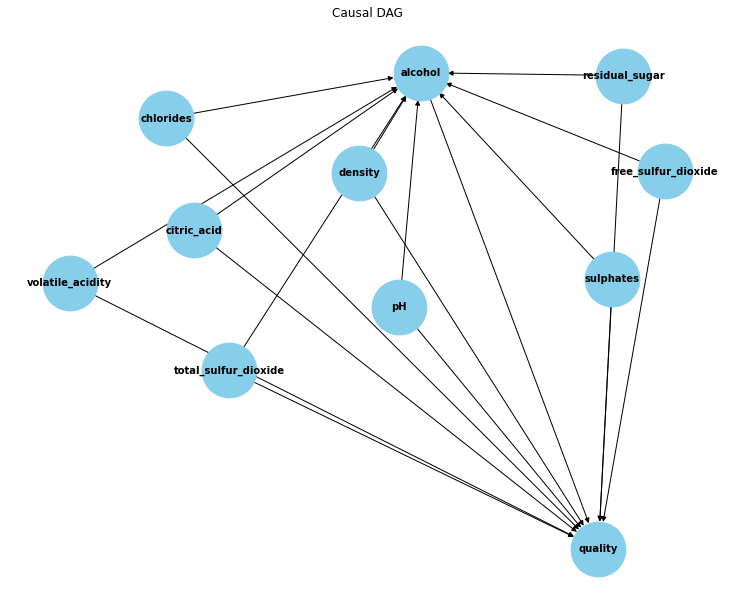

In [20]:
## DAG

import networkx as nx

# Define the edges for your causal graph
edges = [
    ("alcohol", "quality"),
    ("volatile_acidity", "quality"),
    ("citric_acid", "quality"),
    ("residual_sugar", "quality"),
    ("chlorides", "quality"),
    ("free_sulfur_dioxide", "quality"),
    ("total_sulfur_dioxide", "quality"),
    ("density", "quality"),
    ("pH", "quality"),
    ("sulphates", "quality"),
    ("volatile_acidity", "alcohol"),
    ("citric_acid", "alcohol"),
    ("residual_sugar", "alcohol"),
    ("chlorides", "alcohol"),
    ("free_sulfur_dioxide", "alcohol"),
    ("total_sulfur_dioxide", "alcohol"),
    ("density", "alcohol"),
    ("pH", "alcohol"),
    ("sulphates", "alcohol")
]

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
G.add_edges_from(edges)

# Generate the plot using networkx
plt.figure(figsize=(10, 8))  # Optional: Set the figure size
pos = nx.spring_layout(G, seed=42)  # Layout for node positions
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
plt.title("Causal DAG")
plt.show()

In [1]:
# pip install causalgraphicalmodels

In [11]:
%matplotlib inline
from causalgraphicalmodels import CausalGraphicalModel

# Define the causal graph structure
dag = CausalGraphicalModel(
    nodes=["alcohol", "quality", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides",
           "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates"],
    edges=[
        ("alcohol", "quality"),  # alcohol influences wine quality
        ("volatile_acidity", "quality"),  # confounders that affect wine quality
        ("citric_acid", "quality"),
        ("residual_sugar", "quality"),
        ("chlorides", "quality"),
        ("free_sulfur_dioxide", "quality"),
        ("total_sulfur_dioxide", "quality"),
        ("density", "quality"),
        ("pH", "quality"),
        ("sulphates", "quality"),
        ("volatile_acidity", "alcohol"),  # confounders that could affect alcohol content
        ("citric_acid", "alcohol"),
        ("residual_sugar", "alcohol"),
        ("chlorides", "alcohol"),
        ("free_sulfur_dioxide", "alcohol"),
        ("total_sulfur_dioxide", "alcohol"),
        ("density", "alcohol"),
        ("pH", "alcohol"),
        ("sulphates", "alcohol")
    ]
)

# Visualize the DAG
dag.draw()
plt.show()

---
#### 3-2. What is the effect of acidity (pH and fixed acidity) on wine quality, controlling for confounders?
    
**Inverse Probability Weighting (IPW)**  
IPW is a good approach when working with continuous treatments (like acidity), especially when you want to control for confounders. By properly weighting observations based on their likelihood of receiving a particular level of acidity, you can estimate the causal effect of acidity on wine quality.

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Assume df is your DataFrame and 'quality' is the outcome variable
# Define treatment variables (pH and fixed acidity)
treatment_pH = df['pH']  # pH as a continuous treatment variable
treatment_acidity = df['fixed acidity']  # Fixed acidity as a continuous treatment variable

# Outcome variable: Wine quality
outcome = "quality"

# Confounders
confounders = ['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
               'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates']

# Standardize the confounders
scaler = StandardScaler()
df[confounders] = scaler.fit_transform(df[confounders])

# Estimate the propensity score for pH using a regression model
propensity_model_pH = LinearRegression()
propensity_model_pH.fit(df[confounders], treatment_pH)
propensity_scores_pH = propensity_model_pH.predict(df[confounders])

# Estimate the propensity score for fixed acidity using a regression model
propensity_model_acidity = LinearRegression()
propensity_model_acidity.fit(df[confounders], treatment_acidity)
propensity_scores_acidity = propensity_model_acidity.predict(df[confounders])

# Calculate weights (inverse of propensity scores)
weights_pH = 1 / propensity_scores_pH
weights_acidity = 1 / propensity_scores_acidity

# Now, estimate the causal effect using weighted regression for pH or fixed acidity treatment
weighted_model_pH = LinearRegression()
weighted_model_pH.fit(df[confounders], df[outcome], sample_weight=weights_pH)

weighted_model_acidity = LinearRegression()
weighted_model_acidity.fit(df[confounders], df[outcome], sample_weight=weights_acidity)

# Get the coefficients (effect of pH and fixed acidity on wine quality)
coefficients_pH = weighted_model_pH.coef_
coefficients_acidity = weighted_model_acidity.coef_

print(f"Effect of pH on wine quality: {coefficients_pH}")
print(f"Effect of fixed acidity on wine quality: {coefficients_acidity}")

Effect of pH on wine quality: [-0.15663731  0.13346633  0.10171864 -0.15754877  0.0562246  -0.18835611
 -0.20687448  0.21178558]
Effect of fixed acidity on wine quality: [-0.16134028  0.12527909  0.09838112 -0.15554099  0.05220932 -0.17124665
 -0.22381335  0.22202938]


In [56]:
import statsmodels.api as sm

# Add a constant to the confounders matrix
X = sm.add_constant(df[confounders])

# For pH treatment effect
model_pH = sm.WLS(df[outcome], X, weights=weights_pH)
result_pH = model_pH.fit()

# For fixed acidity treatment effect
model_acidity = sm.WLS(df[outcome], X, weights=weights_acidity)
result_acidity = model_acidity.fit()

# Print summary to get p-values and confidence intervals
print(result_pH.summary())
print(result_acidity.summary())

                            WLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.291
Model:                            WLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     81.48
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          5.00e-113
Time:                        13:35:47   Log-Likelihood:                -1652.7
No. Observations:                1599   AIC:                             3323.
Df Residuals:                    1590   BIC:                             3372.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6360 